# Adatbetöltés

In [1]:
!pip install torch torchvision wandb pytorch_lightning

import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import wandb
from PIL import Image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torchmetrics
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from torch.optim.lr_scheduler import StepLR
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 19.9 MB/s eta 0:00:00


In [3]:
seed = 11
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)

from google.colab import drive
drive.mount('/content/drive')

# Az elérési utakat lehet, hogy meg kell változtatni!
images_folder = '/content/drive/MyDrive/images'
labels_file = '/content/drive/MyDrive/labels.xlsx'

#images_folder = '/content/drive/MyDrive/data/images'
#labels_file = '/content/drive/MyDrive/data/labels.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Szükséges függvények és osztályok definiálása

In [4]:
# Éldetektálás
class ToEdgeDetection:
    def __call__(self, image):
        grayscale_image = transforms.functional.rgb_to_grayscale(image, num_output_channels=1)
        image_np = np.array(grayscale_image)
        # Canny éldetektálás
        edges = cv2.Canny(image_np, threshold1=60, threshold2=120)
        edge_tensor = torch.tensor(edges / 255.0, dtype=torch.float32).unsqueeze(0)
        return edge_tensor.expand(3, -1, -1)

# Adathalmaz betöltése, létrehozása
class ChessDataset(Dataset):
    def __init__(self, images_folder, labels_file, img_size, transform=None):
        self.images_folder = images_folder
        self.labels = pd.read_excel(labels_file)
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_name = self.labels.iloc[idx]['name']
        image_path = os.path.join(self.images_folder, image_name)

        try:
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            label = self.labels.iloc[idx]['label']
            label = label - 1
            return image, label
        except Exception as e:
            print(f"hiba a kép betöltésekor: {image_path}, hiba: {e}")
            return image, -1

# A szükséges átalakítási lépések megtétele, tanuló-validációs-teszthalmaz létrehozása
def create_data_loaders(images_folder, labels_file, img_size, batch_size, seed):
    transform = transforms.Compose([
        transforms.RandomResizedCrop(size=img_size, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        ToEdgeDetection(),  # Kontúrozás
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    dataset = ChessDataset(images_folder, labels_file, img_size, transform)

    torch.manual_seed(seed)

    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## Példa augmentált kép

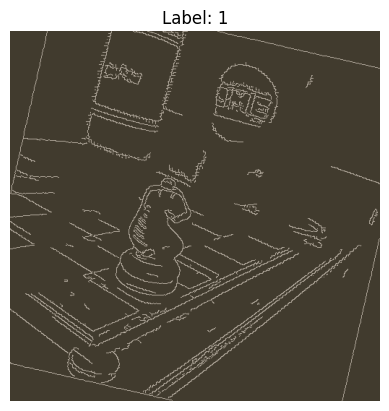

In [8]:
train_loader, val_loader, test_loader = create_data_loaders(images_folder, labels_file, img_size=(512,512), batch_size=10, seed=11)
data_iter = iter(train_loader)
images, labels = next(data_iter)

unnormalized_image = images[1].permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
unnormalized_image = torch.clamp(unnormalized_image, 0, 1)

plt.imshow(unnormalized_image.numpy())
plt.title(f"Label: {labels[1].item()}")
plt.axis('off')
plt.show()

## Képosztályozó modell

In [9]:
class ImageClassifier(pl.LightningModule):
    def __init__(self, model, num_classes, learning_rate):
        super().__init__()
        self.model = model
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.learning_rate = learning_rate
        self.test_predictions = []
        self.test_labels = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        pred_labels = self(images)

        loss = F.cross_entropy(pred_labels, labels)
        accuracy = self.accuracy(pred_labels, labels)

        self.log("train_acc", accuracy, on_epoch=True)
        self.log("train_acc", accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        pred_labels = self(images)

        loss = F.cross_entropy(pred_labels, labels)
        accuracy = self.accuracy(pred_labels, labels)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", accuracy, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        pred_labels = self(images)

        loss = F.cross_entropy(pred_labels, labels)
        accuracy = self.accuracy(pred_labels, labels)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)

        self.test_predictions.append(pred_labels)
        self.test_labels.append(labels)

        return loss

    def on_test_epoch_end(self):
        self.test_predictions = torch.cat(self.test_predictions).cpu().float().numpy()
        self.test_labels = torch.cat(self.test_labels).cpu().numpy()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def get_test_predictions(self):
        return self.test_predictions, self.test_labels

## Hiperparaméterek

In [11]:
num_classes = 3
img_size = (512, 512)
batch_size = 10
num_epochs = 3

# Modellezés

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.467


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5333333611488342     │
│         test_loss         │     52.77851104736328     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆▆█
test_acc,▁
test_loss,▁
train_acc_epoch,▁█▄
train_acc_step,▄▂▂▄▅▂▄▇█▄▂▁▇▇▂▂▂▂▅▇▇▇▇▁▂▇▅▁▅▅▄▂▂▇▂▇
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,██▁
val_loss,▁▁█
epoch,3
test_acc,0.53333
test_loss,52.77851


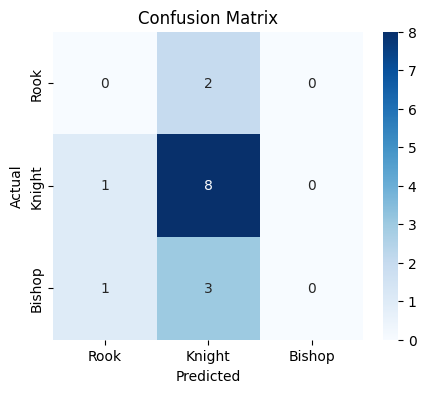

wandb: Currently logged in as: wiederschitz-diana (wiederschitz-diana-budapest-university-of-technology-and). Use `wandb login --relogin` to force relogin


0.5333333333333333


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.467


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6000000238418579     │
│         test_loss         │    1.0134440660476685     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆▆█
test_acc,▁
test_loss,▁
train_acc_epoch,▁█▂
train_acc_step,▄▃▃▄▅▃▄▆▄▂▅▂▆▇▄▇▃▆▅▃▅▃█▃█▅▄▁▄▅▃▅▄▃▁▄
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,█▁▅
val_loss,█▁▁
epoch,3
test_acc,0.6
test_loss,1.01344


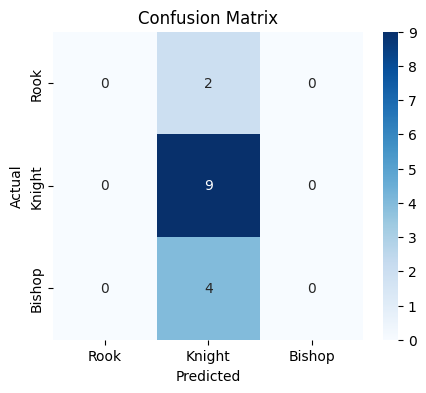

0.6


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.467


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.46666666865348816    │
│         test_loss         │    16.365665435791016     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆▆█
test_acc,▁
test_loss,▁
train_acc_epoch,▁▅█
train_acc_step,▄▃▃▄▅▃▄▆▄▂▃▂▆▁▄▄▅▄▅▃▃▃▇▃█▆▄▅▃▃▄▅▄▄▄▃
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,█▁█
val_loss,█▄▁
epoch,3
test_acc,0.46667
test_loss,16.36567


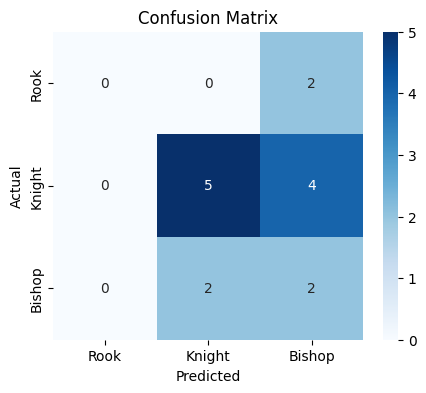

0.4666666666666667


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.200


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.133 >= min_delta = 0.0. New best score: 0.333
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.2666666805744171     │
│         test_loss         │     7.863587379455566     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆▆█
test_acc,▁
test_loss,▁
train_acc_epoch,▁▃█
train_acc_step,▃▂▂▃▅▂▃▆▃▁▂▅▃▇▃▅▂▅▅▂▂▅▃▂█▇▂▅▃▆▃▇▅▆▅▂
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▁█
val_loss,█▁
epoch,3
test_acc,0.26667
test_loss,7.86359


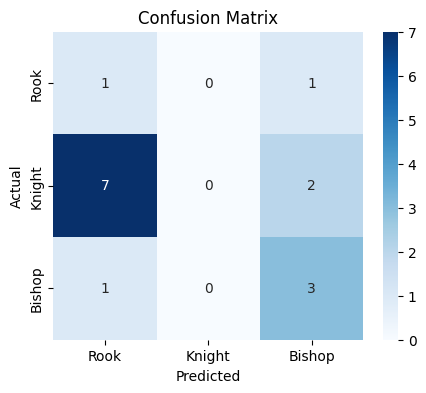

0.26666666666666666


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.333


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.46666666865348816    │
│         test_loss         │    1.4960448741912842     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆▆█
test_acc,▁
test_loss,▁
train_acc_epoch,▃▁█
train_acc_step,▄▃▃▄▅▅▇▃▅▄▇▃▄▅▄▅▅▃▄▅▅▅▆▁█▅▆▂▅▇▄▃▄▄▅▃
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,█▁█
val_loss,█▅▁
epoch,3
test_acc,0.46667
test_loss,1.49604


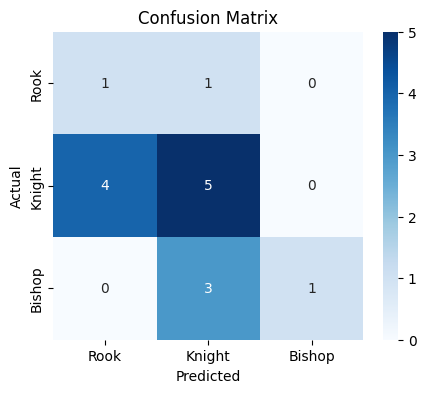

0.4666666666666667


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.333


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.067 >= min_delta = 0.0. New best score: 0.400


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.067 >= min_delta = 0.0. New best score: 0.467
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.46666666865348816    │
│         test_loss         │    1.2685831785202026     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆▆█
test_acc,▁
test_loss,▁
train_acc_epoch,▁▄█
train_acc_step,▄▃▃▄▅▃▄▃▄▅▆▃▂▅▁▇▃▅▃▆▇▅▄▄█▅▆▃▅▄▅▃▆▃▅▅
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▅█
val_loss,█▂▁
epoch,3
test_acc,0.46667
test_loss,1.26858


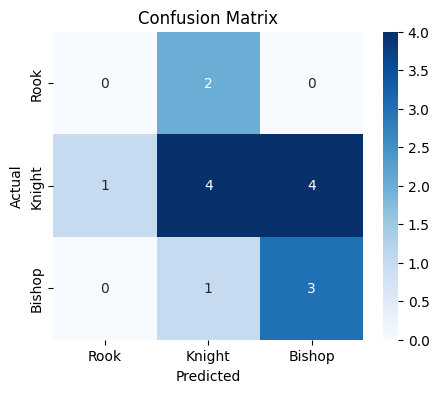

0.4666666666666667


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.267


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.133 >= min_delta = 0.0. New best score: 0.400
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.20000000298023224    │
│         test_loss         │    2.2170979976654053     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆▆█
test_acc,▁
test_loss,▁
train_acc_epoch,▆▁█
train_acc_step,▃▂▂▃▅▂▃▆▅▅▇▂▁▂▃▃▃▅▂▃▂▆▆▁█▆▂▃▃▂▃▅▆▃▃▃
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,▃▁█
val_loss,█▅▁
epoch,3
test_acc,0.2
test_loss,2.2171


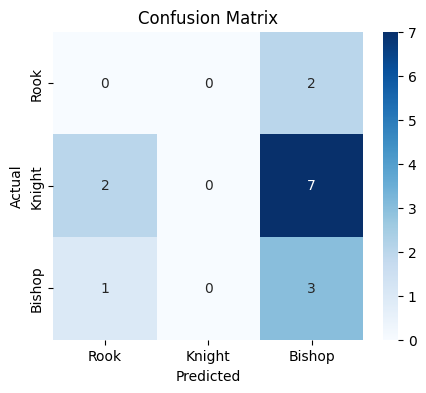

0.2


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.333


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.13333334028720856    │
│         test_loss         │    14.323026657104492     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆▆█
test_acc,▁
test_loss,▁
train_acc_epoch,▃▁█
train_acc_step,▃▂▂▃▄▂▃▅▃▄▆▃▂▂▄▄▄▂▂▄▃▅▅▂█▅▂▅▃▃▂▂▅▁▃▃
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,█▁▅
val_loss,█▂▁
epoch,3
test_acc,0.13333
test_loss,14.32303


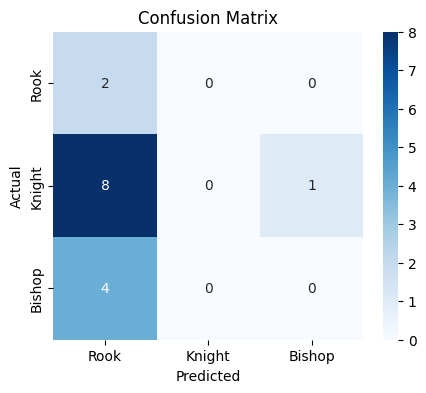

0.13333333333333333


In [13]:
for learning_rate in [0.01, 0.025, 0.05, 0.075, 0.001, 0.0025, 0.005, 0.0075]:
      wandb.init(
          project="chess_final",
          name=f"learning_rate = {learning_rate}",
          config={
              "learning_rate": learning_rate}
      )


      model = torch.nn.Sequential(
          nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.AdaptiveAvgPool2d(output_size=(4, 4)),

          nn.Flatten(),
          nn.Linear(512 * 4 * 4, 512),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.Linear(512, num_classes)
      )

      lit_model = ImageClassifier(model=model, num_classes=num_classes, learning_rate=learning_rate)

      wandb_logger = pl.loggers.WandbLogger(log_model="all")
      checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_acc", mode="max", dirpath=".", filename=f"model{learning_rate}")
      early_stopping_callback = EarlyStopping(
          monitor='val_acc',
          patience=3,
          mode='max',
          verbose=True
      )

      trainer = pl.Trainer(
          log_every_n_steps=1,
          max_epochs=num_epochs,
          precision="16-mixed",
          accelerator="gpu",
          devices=1,
          logger=wandb_logger,
          callbacks=[checkpoint_callback, early_stopping_callback],
      )

      train_loader, val_loader, test_loader = create_data_loaders(images_folder, labels_file, img_size, batch_size, seed)
      trainer.fit(lit_model, train_loader, val_loader)
      trainer.test(lit_model, test_loader)

      wandb.finish()

      predictions, true_labels = lit_model.get_test_predictions()
      probabilities = F.softmax(torch.tensor(predictions), dim=1)
      predicted_classes = torch.argmax(probabilities, dim=1)

      cm = confusion_matrix(true_labels, predicted_classes)

      plt.figure(figsize=(5, 4))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rook', 'Knight', 'Bishop'],
            yticklabels=['Rook', 'Knight', 'Bishop'])
      plt.ylabel('Actual')
      plt.xlabel('Predicted')
      plt.title('Confusion Matrix')
      plt.show()

      correct_predictions = cm.diagonal().sum()
      total_predictions = cm.sum()
      test_accuracy = correct_predictions / total_predictions
      print(test_accuracy)

      # cb287032b3b9fe50af7194d915f55c0af69047f3